<a href="https://colab.research.google.com/github/olivieromassi/Hysteresis-Modelling-with-Neural-Networks/blob/main/PreisachRNNWDModelTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Necessary imports to configure the environment.


In [ ]:
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

import os
import collections
import json
from google.colab import files

SEED = 42

tf.random.set_seed(SEED)
np.random.seed(SEED)

Getting the Dataset from the Github repository:

In [ ]:
!wget https://github.com/olivieromassi/Hysteresis-Modelling-with-Neural-Networks/raw/main/Dataset/P2_measurements.zip
!unzip P2_measurements.zip -d P2_measurements

The Hysteresis Dataset is downloaded from the Github repository and stored into a dictionary. 

Given the core topology, $H$ and $B$ are converted into $ℱ$ and $\phi$ using the formulas:

$ ℱ = H \cdot \Gamma$

$ \phi = B \cdot \Lambda$ 

Being $\Lambda$ the cross-section and $\Gamma$ the length of the magnetic path.

The core geometry chosen is the Grau UI60:

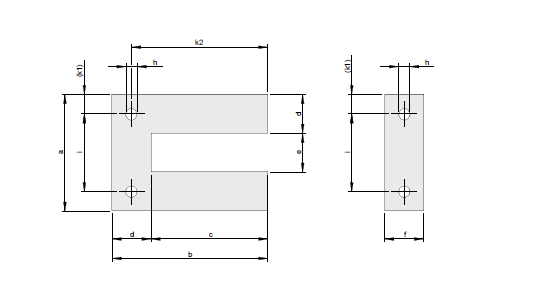

$\Gamma = 24 \times 10^{-2} m$

$\Lambda = 4 \times 10^{-4} m^2$

Additionally, the Kirchhoff variables are transformed into the corresponding Wave Digital Variables $a$ and $b$:

$a = ℱ + Z \cdot \phi$

$b = ℱ - Z \cdot \phi$


Where the free-parameter is fixed $Z = 23337931.03448276$

In [ ]:
# Grau UI60 Core Parameters:
gamma = 24e-2 # m
lamda = 4e-4 # m^2

# Circuit Parameters
Z = 23337931.03448276

In [ ]:
cwd = "/content/P2_measurements"

# Set the following flag to True to consider the whole Hysteresis Curve, including
# the first Magnetization curve.
include_first_magnetization = False

# Creating a dictionary containing all the measurements divided by frequency
dataset_kirch = {}
dataset_wd = {}

amax = []
amin = []

bmax = []
bmin = []

columns = ["t", "B", "H", "-H"] # t: timestamp, B: Magnetic Flux Density, H: Magnetic Field 

for file in os.listdir(cwd):
    temp_data = pd.read_csv(os.path.join(cwd, file),sep=';', header=None, names=columns)

    temp_data_reluctance = pd.DataFrame(columns=['F', 'phi'])
    temp_data_reluctance['F'] = gamma * temp_data[['H']]
    temp_data_reluctance['phi'] = lamda * temp_data[['B']]

    temp_data_wd = pd.DataFrame(columns=['a', 'b'])
    temp_data_wd['a'] = temp_data_reluctance['F'] + Z * temp_data_reluctance['phi']
    temp_data_wd['b'] = temp_data_reluctance['F'] - Z * temp_data_reluctance['phi']

    amax.append(temp_data_wd['a'].max())
    amin.append(temp_data_wd['a'].min())

    bmax.append(temp_data_wd['b'].max())
    bmin.append(temp_data_wd['b'].min())

    if include_first_magnetization:
        dataset_kirch[file] = temp_data_reluctance
        dataset_wd[file] = temp_data_wd
    else:
        # Select only the second half of the curve
        dataset_kirch[file] = temp_data_reluctance[int(len(temp_data)/2):].reset_index(drop=True)
        dataset_wd[file] = temp_data_wd[int(len(temp_data)/2):].reset_index(drop=True)

dataset_kirch = collections.OrderedDict(sorted(dataset_kirch.items(), key=lambda t: t[1].shape, reverse=True))
dataset_wd = collections.OrderedDict(sorted(dataset_wd.items(), key=lambda t: t[1].shape, reverse=True))

# Computing the global max and min value of a
amax = max(amax)
amin = min(amin)

# Computing the global max and min value of b
bmax = max(bmax)
bmin = min(bmin)

Rescale the Wave Digital Dataset between $-1$ and $1$ using the globally computed $a_{max}, a_{min}, b_{max}, b_{min}$

In [ ]:
dataset = {}

for freq in dataset_wd:
    temp_data_norm = pd.DataFrame(columns=['a', 'a_dot', 'b'])

    temp_data_norm['a'] = dataset_wd[freq]['a'].apply(lambda x: (1 - (-1)) * ((x - amin) / (amax - amin)) + (-1))
    temp_data_norm['b'] = dataset_wd[freq]['b'].apply(lambda x: (1 - (-1)) * ((x - bmin) / (bmax - bmin)) + (-1))
    
    temp_data_norm['a_dot'] = np.gradient(temp_data_norm['a'], axis=0)

    dataset[freq] = temp_data_norm

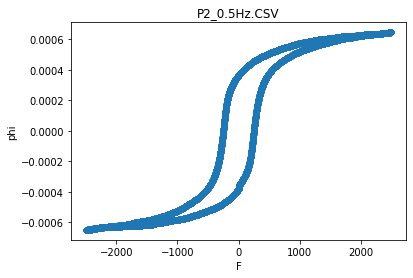

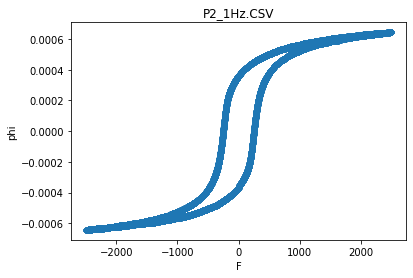

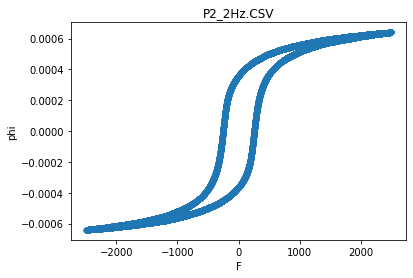

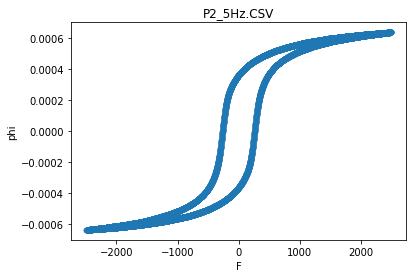

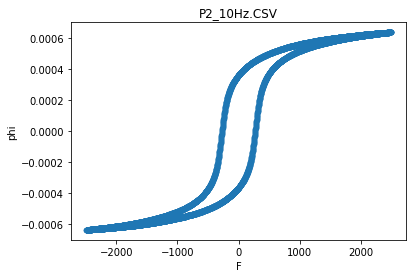

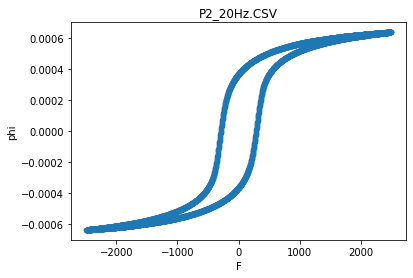

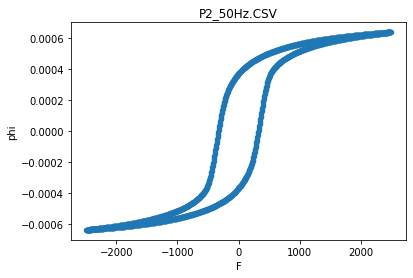

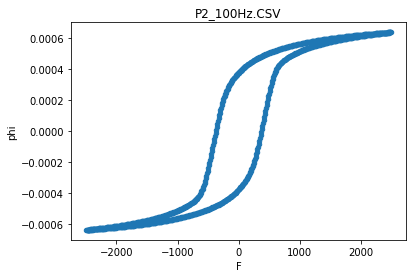

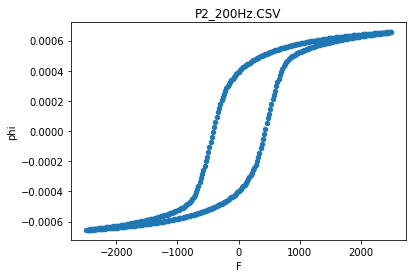

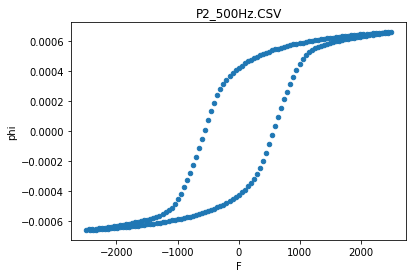

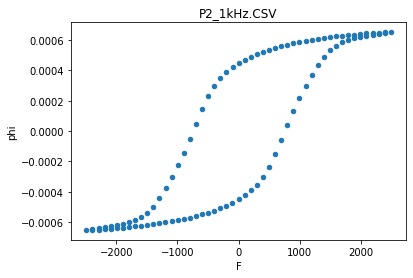

In [ ]:
# Plotting F-phi Training Dataset
for freq in dataset_kirch:
    dataset_kirch[freq].plot.scatter('F', 'phi', title=freq)

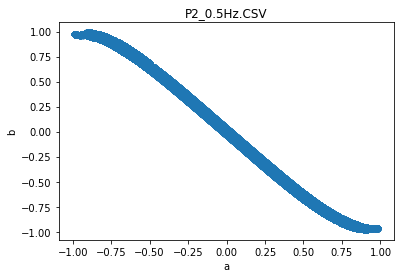

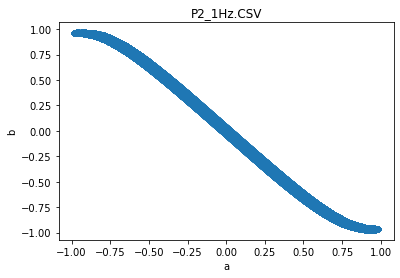

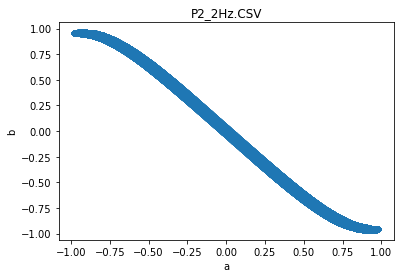

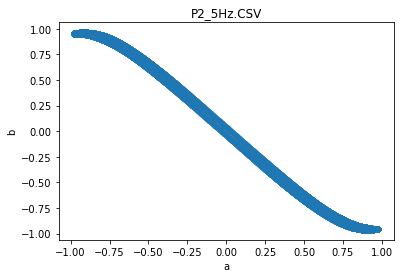

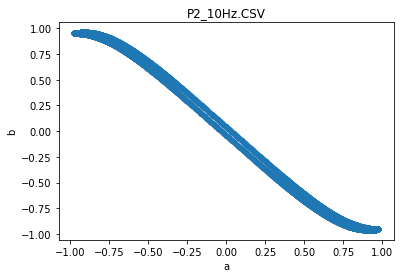

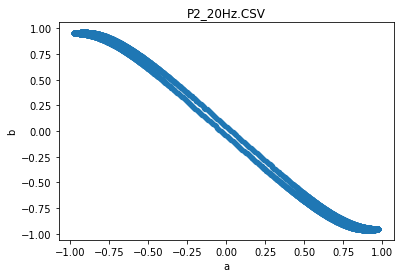

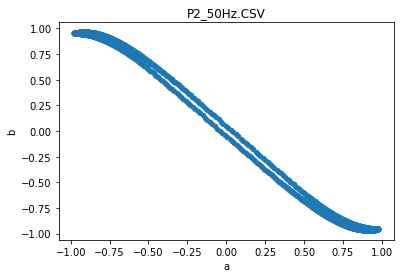

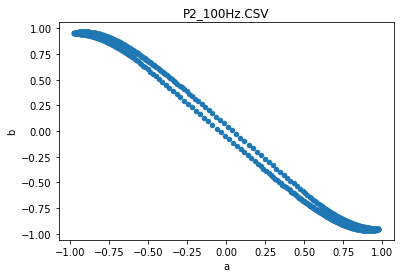

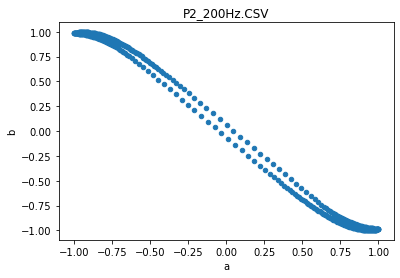

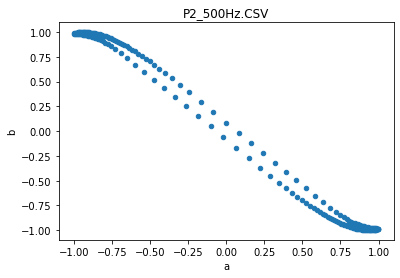

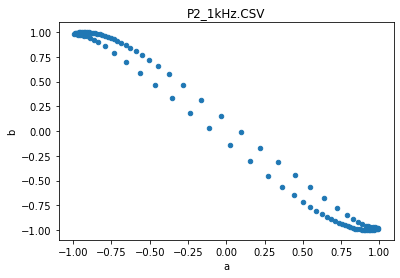

In [ ]:
# Plotting the Wave Digital Training Dataset
for freq in dataset:
    dataset[freq].plot.scatter('a', 'b', title=freq)

In [ ]:
# Plotting the Wave Digital a variable
for freq in dataset:
    plt.figure()
    plt.plot(dataset[freq].index, dataset[freq]['a'])

Roll the signals to let them start from the Saturation value (rolling back $1/4$ of a period)

In [ ]:
# Set the flag to True to let the signals start from the saturation point
start_from_sat = True

if start_from_sat:
    for freq in dataset:
        dataset[freq] = dataset[freq].reindex(np.roll(dataset[freq].index, -len(dataset[freq])//4)).reset_index(drop=True)

Repeat the signals for a fixed number of times and resample them to a new `resample_fs` (audio sampling frequency: $48 kHz, 96 kHz$)

In [ ]:
import scipy as sp
"""
This method is used to resample the DataFrame signals contained in a dictionary
:param data: dictionary containing the curves indexed by frequency
:columns: columns of the Dataframe to resample
:param repetitions: if greater than one, the represented curve period is repeated
multiple times
:param resample_fs: frequency to resample the signal to
:param fs: starting sampling frequency
:return: dictionary containing the resampled curves indexed by frequency
"""
def resample_dataset(data, columns, repetitions, resample_fs, fs):
    resampled_dataset = collections.OrderedDict()
    
    for freq in data:
        num_sample = len(data[freq]) * repetitions
        num_sample_sub = int(num_sample / fs * resample_fs)

        resampled_dataset[freq] = pd.DataFrame(sp.signal.resample(np.tile(data[freq], (repetitions, 1)), num_sample_sub), columns=columns)

    return resampled_dataset

In [ ]:
# Resample the dataset signals:
fs = 1e5
resample_fs = 96e3 # or 44.1e3, 48e3, 96e3

repetitions = 2
dataset = resample_dataset(data=dataset, columns=['a', 'a_dot', 'b'], repetitions=repetitions, resample_fs=resample_fs, fs=fs)

Building the *Training Set*. The median frequency curve (H at 20 Hz) is excluded from training and used for validation purposes.

In [ ]:
train_dataset = collections.OrderedDict()

for freq in dataset:
    if freq != 'P2_20Hz.CSV':
        train_dataset[freq] = dataset[freq]

Building the *Validation Set*. It includes the 20 Hz curve.

In [ ]:
val_dataset = collections.OrderedDict()

for freq in dataset:
    if freq == 'P2_20Hz.CSV':
        val_dataset[freq] = dataset[freq]

# PreisachRNN Model Training:

In [ ]:
# Defining some of the Network and Sequence parameters:
# For training purposes, the sequence length is fixed to 20
seq_len = 20
n_train_signals = len(train_dataset)

### Preisach Memory Layer Definition:

In [ ]:
from tensorflow.math import maximum, minimum

class PreisachMemoryLayer(tf.keras.layers.Layer):
    def __init__(self, n_operators, batch_size, stateful, input_min=-1, input_max=1, **kwargs):
        super(PreisachMemoryLayer, self).__init__(**kwargs)
        self.batch_size = batch_size
        self.n_operators = n_operators
        
        self.first_batch = True
        self.stateful = stateful
        
        self.input_min = input_min
        self.input_max = input_max
    
    def build(self, input_shape):
        self.input_dim = input_shape

        if self.input_dim[0] == None:
            raise ValueError(f'The Preisach Layer cannot instantiate the set of Play Operators for batch_size = None.'
            + '\n Set an integer value for the batch_size.')

        self.play_operators = tf.Variable(name='PlayOperators', 
                                          initial_value=tf.zeros((input_shape[0], input_shape[1], self.n_operators)), 
                                          trainable=False)
        self.prev_play_operators = tf.Variable(name='PrevPlayOperators',
                                               initial_value=tf.zeros((input_shape[0], self.n_operators)),
                                               trainable=False) 
        self.r = np.zeros(self.n_operators)
        
        for j in range(self.n_operators):
            # Since the input signal is required to be normalized between -1 and 1,
            # the values of input_min and input_max are respectively -1 and 1.
            self.r[j] = (j / self.n_operators) * (self.input_max - (self.input_min))
        
    def call(self, inputs):
        for t in range(self.input_dim[1]):
            for j in range(self.n_operators):
                if t == 0:
                    if self.first_batch:
                        self.play_operators[:, t, j].assign(maximum(inputs[:, t, 0] - self.r[j], minimum(inputs[:, t, 0] + self.r[j], 0))) 
                    else:
                        self.play_operators[:, t, j].assign(maximum(inputs[:, t, 0] - self.r[j], minimum(inputs[:, t, 0] + self.r[j], self.prev_play_operators[:, j])))
                else:
                    self.play_operators[:, t, j].assign(maximum(inputs[:, t, 0] - self.r[j], minimum(inputs[:, t, 0] + self.r[j], self.play_operators[:, t - 1, j])))
                
        if self.first_batch and self.stateful:
            self.first_batch = False
        
        self.prev_play_operators.assign(self.play_operators[:, t, :])
        
        # The following comment is used as a reference for the Play Operators definition
        # P_j(t) = max(u(t) - r_j, min(u(t) + r_j, P_j(t - 1)))
        # P_j(0) = max(u(0) - r_j, min(u(0) + r_j, k0))
        # r_j = (j - 1)/n * (max(u(t)) - min(u(t)))  j = 1, ..., n
        return self.play_operators
    
    def reset_first_batch(self):
        self.fist_batch = True

## Training with Stateful = True

In [ ]:
# To have cross-batch statefulness set stateful = True
stateful = True

In [ ]:
"""
This method is used to  batch the signals contained in a dictionary
:param data: dictionary containing the curves indexed by frequency
:param seq_len: it refers to the length of each input sequence in the batch (must
be a common divider of all the curves lengths)
:param stride: it refers to the distance in sample between successive windows
"""
def batch_data(data, seq_len, stride):
    batch_size = len(data)

    num_sample_max = max([x.shape[0] for x in data.values()])
    
    a_set = np.zeros((batch_size, num_sample_max))
    a_dot_set = np.zeros((batch_size, num_sample_max))
    b_set = np.zeros((batch_size, num_sample_max))

    for index, freq in enumerate(data):
        repeat = num_sample_max // len(data[freq])
        a_set[index, :] = np.tile(data[freq]['a'], repeat)
        a_dot_set[index, :] = np.tile(data[freq]['a_dot'], repeat)
        b_set[index, :] = np.tile(data[freq]['b'], repeat)

    X = []
    Y = []

    for i in range(0, num_sample_max, stride):
        if (i + seq_len) <= num_sample_max:
            X.append([a_set[:, i : i + seq_len], a_dot_set[:, i : i + seq_len]])
            Y.append(b_set[:, i + seq_len - 1])
    
    return (np.expand_dims(np.array(X), axis=-1), np.expand_dims(np.array(Y), axis=-1))

In [ ]:
X_train, y_train = batch_data(data=train_dataset, seq_len=seq_len, stride=1)
X_val, y_val = batch_data(data=val_dataset, seq_len=seq_len, stride=1)

def map_fn(features, labels):
    return ((features[0, :, :], features[1, :, :]), labels)

train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).map(map_fn)
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).map(map_fn)

Model: "PreisachRNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 a (InputLayer)                 [(10, 20, 1)]        0           []                               
                                                                                                  
 a_dot (InputLayer)             [(10, 20, 1)]        0           []                               
                                                                                                  
 PreisachMemoryLayer_10 (Preisa  (10, 20, 6)         1260        ['a[0][0]']                      
 chMemoryLayer)                                                                                   
                                                                                                  
 ConcatenateLayer (Concatenate)  (10, 20, 8)         0           ['a[0][0]',            

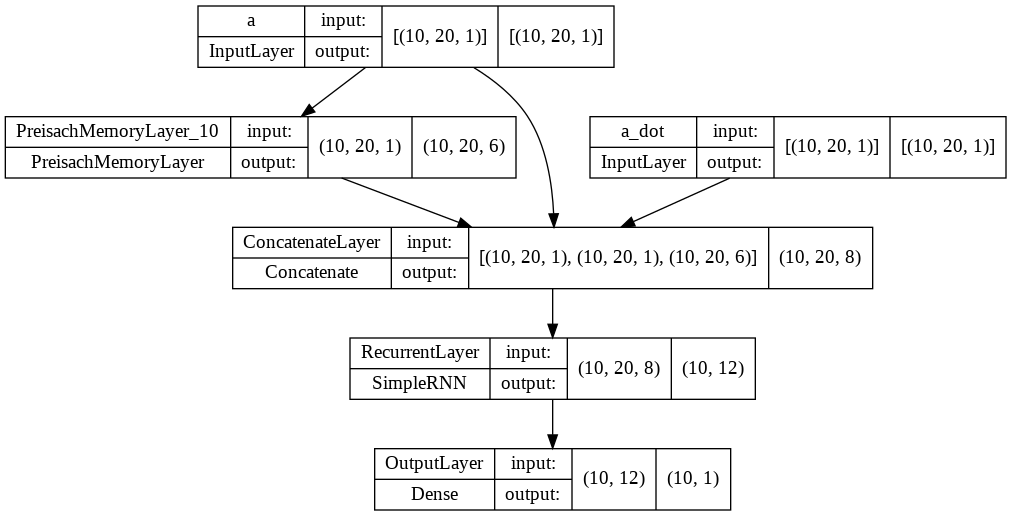

In [ ]:
# Example: building a PreisachRNN using the custom Layer to implement Preisach Memory 
batch_size = n_train_signals
return_sequences = False

# Setting the number of Hidden Neurons to be used by the model
rnn_units = 12
# Setting the number of Play Operators to be used by the model
n_operators = 6

a = tf.keras.layers.Input(shape=(seq_len, 1,), batch_size=batch_size, name='a')
a_dot = tf.keras.layers.Input(shape=(seq_len, 1,), batch_size=batch_size, name='a_dot')

preisach_layer = PreisachMemoryLayer(n_operators=n_operators,
                                     batch_size=batch_size,
                                     stateful=stateful, 
                                     name=f"PreisachMemoryLayer_{batch_size}")(a)

concatenate = tf.keras.layers.concatenate([a, a_dot, preisach_layer], name='ConcatenateLayer')

recurrent_layer = tf.keras.layers.SimpleRNN(units=rnn_units,
                                            return_sequences=return_sequences,
                                            stateful=stateful,
                                            name='RecurrentLayer')(concatenate)
outputs = tf.keras.layers.Dense(1, activation='linear', name='OutputLayer')(recurrent_layer)


model = tf.keras.Model(inputs=[a, a_dot], outputs=outputs, name='PreisachRNN')
model.summary()

tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Optimization parameters

# Mean Squared Error for Regression
loss = tf.keras.losses.MSE 
# Learning rate
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Validation metrics
metrics = [tf.metrics.MeanAbsoluteError()]

In [ ]:
# Compile Model
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

Set the Model's name:

In [ ]:
filename = f'PreisachRNNWD_{rnn_units}_units_seq_len_{seq_len}_stateful_{stateful}_first_magnetization_{include_first_magnetization}_fs_{resample_fs}_repeated_{repetitions}_sat_{start_from_sat}'

Set the Model Training Callbacks

In [ ]:
class ResetStatesAndPlayOperatorsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        model.get_layer(f'PreisachMemoryLayer_{batch_size}').reset_first_batch()
        model.reset_states()

In [ ]:
callbacks = []

# Reset States on epoch end Callback
# ----------------------------------
reset_callback = ResetStatesAndPlayOperatorsCallback()

callbacks.append(reset_callback)

### Batch Training (10 sequences per batch, one for each frequency):
The model is trained with a "stateful" RNN layer.

Weights are tuned after each batch of samples, which include different frequencies.

In [ ]:
# Training over all the dataset fs=96k:

# Setting the number of training epochs
num_epochs = 10

model.fit(train_data, epochs=num_epochs, callbacks=callbacks)

Epoch 1/10
383981/383981 [==============================] - 1745s 5ms/step - loss: 2.3372e-04 - mean_absolute_error: 0.0055
Epoch 2/10
383981/383981 [==============================] - 1719s 4ms/step - loss: 2.0318e-05 - mean_absolute_error: 0.0033
Epoch 3/10
383981/383981 [==============================] - 1681s 4ms/step - loss: 1.5213e-05 - mean_absolute_error: 0.0029
Epoch 4/10
383981/383981 [==============================] - 1683s 4ms/step - loss: 7.7964e-06 - mean_absolute_error: 0.0020
Epoch 5/10
383981/383981 [==============================] - 1668s 4ms/step - loss: 6.7611e-06 - mean_absolute_error: 0.0019
Epoch 6/10
383981/383981 [==============================] - 1614s 4ms/step - loss: 6.4499e-06 - mean_absolute_error: 0.0018
Epoch 7/10
383981/383981 [==============================] - 1654s 4ms/step - loss: 6.1740e-06 - mean_absolute_error: 0.0018
Epoch 8/10
383981/383981 [==============================] - 1673s 4ms/step - loss: 5.2069e-06 - mean_absolute_error: 0.0016
Epoch 9/

## Save the Model Weights

In [ ]:
# Saving the model weights
model.save_weights(filename + '.h5', save_format='h5')

files.download(filename + '.h5')

## Prediction Model:

Model: "PreisachRNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 a (InputLayer)                 [(1, 20, 1)]         0           []                               
                                                                                                  
 a_dot (InputLayer)             [(1, 20, 1)]         0           []                               
                                                                                                  
 PreisachMemoryLayer_1 (Preisac  (1, 20, 6)          126         ['a[0][0]']                      
 hMemoryLayer)                                                                                    
                                                                                                  
 Concatenate (Concatenate)      (1, 20, 8)           0           ['a[0][0]',            

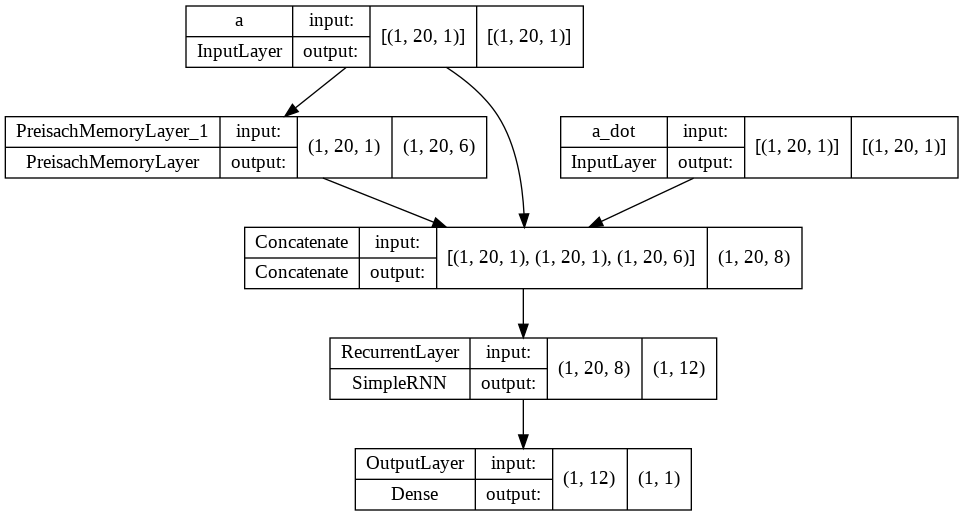

In [ ]:
# Instantiating a prediction model to use a different batch size during prediction

# Setting the number of Hidden Neurons to be used by the model
rnn_units = 12

# Setting the number of Play Operators to be used by the model
n_operators = 6

pred_batch_size = 1

a = tf.keras.layers.Input(shape=(seq_len, 1,), batch_size=pred_batch_size, name='a')
a_dot = tf.keras.layers.Input(shape=(seq_len, 1,), batch_size=pred_batch_size, name='a_dot')

preisach_layer = PreisachMemoryLayer(n_operators=n_operators,
                                     batch_size=pred_batch_size,
                                     stateful=stateful,
                                     name=f"PreisachMemoryLayer_{pred_batch_size}")(a)

concatenate = tf.keras.layers.concatenate([a, a_dot, preisach_layer], name='Concatenate')

recurrent_layer = tf.keras.layers.SimpleRNN(units=rnn_units,
                                            return_sequences=return_sequences,
                                            stateful=stateful,
                                            name='RecurrentLayer')(concatenate)
outputs = tf.keras.layers.Dense(1, activation='linear', name='OutputLayer')(recurrent_layer)


prediction_model = tf.keras.Model(inputs=[a, a_dot], outputs=outputs, name='PreisachRNN')
prediction_model.summary()

tf.keras.utils.plot_model(prediction_model, show_shapes=True)

Take the weights from the just trained model:

In [ ]:
prediction_model.load_weights(filename + '.h5', by_name=True, skip_mismatch=True)

The following method is used to plot model predictions vs. ground truth, with some additional metrics as MSE and MAE.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib.offsetbox import AnchoredText

def plot_prediction(prediction, ground_truth, input_signal, frequency):

    MSE = mean_squared_error(y_true=ground_truth, y_pred=prediction)
    MAE = mean_absolute_error(y_true=ground_truth, y_pred=prediction)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(frequency)

    ax1.set_title('Prediction')
    ax1.scatter(input_signal, prediction)
    ax1.grid(True)
    anchored_text = AnchoredText('MSE:' + str(round(MSE, 6)) + '\n' + 'MAE:' + str(round(MAE, 6)), loc=1)
    ax1.add_artist(anchored_text)

    ax2.set_title('Ground Truth')
    ax2.scatter(input_signal, ground_truth, c='orange')
    ax2.grid(True)

The following cells are used to plot the Predictions over the Validation Set when the model is trained with `stateful = True` and
 `return_sequences = False`

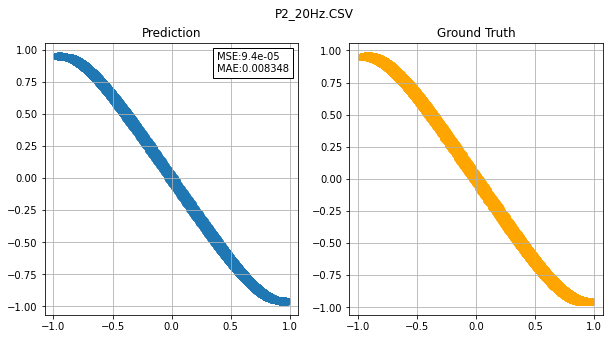

In [ ]:
### DEBUG CELL fs=96k
predictions = prediction_model.predict(val_data)
plot_prediction(predictions, val_dataset['P2_20Hz.CSV']['b'][seq_len - 1:],
                val_dataset['P2_20Hz.CSV']['a'][seq_len - 1:], 'P2_20Hz.CSV')

Use the following cell to generate predictions for a given frequency in the Training Set.

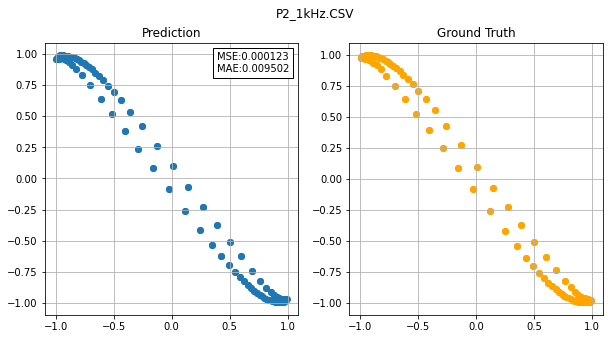

In [ ]:
############# DEBUG ###############
## PREDICTIONS OVER TRAINING DATA #

# Testing the model on the training data, to have an idea of what it is learning
model_predictions = {}
b_pred = []

freq = 'P2_1kHz.CSV'

a = np.array(train_dataset[freq][['a']])
a_dot = np.array(train_dataset[freq][['a_dot']])
b_true = np.array(train_dataset[freq][['b']])

# Reset the model states before computing the predictions
prediction_model.reset_states()
# Reset the Play Operators
prediction_model.get_layer(f'PreisachMemoryLayer_{pred_batch_size}').reset_first_batch()

for i in range(len(a) - seq_len + 1):
    a_i = a[i : i + seq_len]
    a_dot_i = a_dot[i : i + seq_len]

    b_pred.append(prediction_model.predict([np.expand_dims(a_i, axis=0), np.expand_dims(a_dot_i, axis=0)]))
        
# Reshape batch predictions into a single array
b_pred = np.array(b_pred).reshape(-1, 1)

# Store predictions into a dict to be written as a file
model_predictions[freq] = b_pred.tolist()
    
plot_prediction(b_pred, b_true[seq_len - 1:], a[seq_len - 1:], freq)